Classifier Training and Evaluation

Train 5 different classifiers on YAMNet embeddings:
1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting (XGBoost)
4. Support Vector Machine (SVM)
5. Multi-Layer Perceptron (MLP)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, precision_score, 
                             recall_score, roc_auc_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
FEATURES_DIR = '../data/approach1/features'
MODELS_DIR = '../models/models_approach1'
RESULTS_DIR = '../results/results_approach1'
RANDOM_SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1  # From training set
N_FOLDS = 3

# Create directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Set seeds
np.random.seed(RANDOM_SEED)

In [3]:

# LOAD FEATURES AND LABELS

print("LOADING DATA")
X = np.load(os.path.join(FEATURES_DIR, 'yamnet_features.npy'))
y = np.load(os.path.join(FEATURES_DIR, 'yamnet_labels.npy'))
metadata = pd.read_csv(os.path.join(FEATURES_DIR, 'yamnet_features_metadata.csv'))

print(f"\nLoaded features: {X.shape}")
print(f"Loaded labels: {y.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
classes = label_encoder.classes_

print(f"\nClasses ({len(classes)}): {', '.join(classes)}")
print("\nClass distribution:")
for idx, cls in enumerate(classes):
    count = np.sum(y_encoded == idx)
    print(f"  {cls}: {count} ({count/len(y_encoded)*100:.1f}%)")

LOADING DATA

Loaded features: (11906, 1024)
Loaded labels: (11906,)

Classes (5): Alarm_Clock, Car_Horn, Glass_Breaking, Gunshot, Siren

Class distribution:
  Alarm_Clock: 2450 (20.6%)
  Car_Horn: 2325 (19.5%)
  Glass_Breaking: 2394 (20.1%)
  Gunshot: 2355 (19.8%)
  Siren: 2382 (20.0%)


In [4]:
# TRAIN-TEST SPLIT

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=y_train_full
)

print(f"\nSplit sizes:")
print(f"  Training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling (important for SVM and MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save scaler
scaler_path = os.path.join(MODELS_DIR, 'feature_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"\nSaved scaler to: {scaler_path}")

# Save label encoder
label_encoder_path = os.path.join(MODELS_DIR, 'label_encoder.pkl')
joblib.dump(label_encoder, label_encoder_path)
print(f"\nSaved label encoder to: {label_encoder_path}")


Split sizes:
  Training: 8571 (72.0%)
  Validation: 953 (8.0%)
  Test: 2382 (20.0%)

Saved scaler to: ../models/models_approach1\feature_scaler.pkl

Saved label encoder to: ../models/models_approach1\label_encoder.pkl


In [5]:
# DEFINE CLASSIFIERS
classifiers = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, n_jobs=-1),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        },
        'scaled': True
    },
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt']
        },
        'scaled': False
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(
            random_state=RANDOM_SEED, 
            n_jobs=-1,
            objective='multi:softprob', 
            eval_metric='mlogloss'
        ),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'scaled': False
    },
    'SVM': {
        'model': SVC(random_state=RANDOM_SEED, probability=True, cache_size=1000),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale', 'auto']
        },
        'scaled': True
    },
    'MLP': {
        'model': MLPClassifier(
            random_state=RANDOM_SEED, 
            max_iter=300,
            early_stopping=True,
            n_iter_no_change=10
        ),
        'params': {
            'hidden_layer_sizes': [(256,), (512,), (256, 128)],
            'activation': ['relu'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['adaptive']
        },
        'scaled': True
    }
}


print("\nClassifiers to train:")
for name in classifiers.keys():
    print(f"  - {name}")


Classifiers to train:
  - Logistic_Regression
  - Random_Forest
  - SVM
  - MLP


In [6]:
# TRAINING LOOP WITH GRID SEARCH

results = {}
best_models = {}

for clf_name, clf_config in classifiers.items():
    print(f"\n{'='*70}")
    print(f"Training: {clf_name}")
    print(f"{'='*70}")
    
    # Select scaled or unscaled data
    if clf_config['scaled']:
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
        X_test_use = X_test
    
    # Grid search with cross-validation
    print(f"\nPerforming GridSearchCV with {N_FOLDS}-fold CV...")
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    
    grid_search = GridSearchCV(
        clf_config['model'],
        clf_config['params'],
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_use, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV F1-score: {grid_search.best_score_:.4f}")
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_models[clf_name] = best_model
    
    # Predictions
    y_val_pred = best_model.predict(X_val_use)
    y_test_pred = best_model.predict(X_test_use)
    
    # Probabilities for AUC
    y_val_proba = best_model.predict_proba(X_val_use)
    y_test_proba = best_model.predict_proba(X_test_use)
    
    # Compute metrics
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision_macro': precision_score(y_val, y_val_pred, average='macro'),
        'recall_macro': recall_score(y_val, y_val_pred, average='macro'),
        'f1_macro': f1_score(y_val, y_val_pred, average='macro'),
        'f1_weighted': f1_score(y_val, y_val_pred, average='weighted')
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision_macro': precision_score(y_test, y_test_pred, average='macro'),
        'recall_macro': recall_score(y_test, y_test_pred, average='macro'),
        'f1_macro': f1_score(y_test, y_test_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    # Store results
    results[clf_name] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'val_predictions': y_val_pred,
        'test_predictions': y_test_pred,
        'val_proba': y_val_proba,
        'test_proba': y_test_proba
    }
    
    # Print validation results
    print(f"\nValidation Metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\nTest Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    # Save model
    model_path = os.path.join(MODELS_DIR, f'{clf_name.lower()}_model.pkl')
    joblib.dump(best_model, model_path)
    print(f"\nSaved model to: {model_path}")


Training: Logistic_Regression

Performing GridSearchCV with 3-fold CV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-score: 0.9107

Validation Metrics:
  accuracy: 0.9213
  precision_macro: 0.9214
  recall_macro: 0.9209
  f1_macro: 0.9210
  f1_weighted: 0.9212

Test Metrics:
  accuracy: 0.9110
  precision_macro: 0.9117
  recall_macro: 0.9108
  f1_macro: 0.9109
  f1_weighted: 0.9111

Saved model to: ../models/models_approach1\logistic_regression_model.pkl

Training: Random_Forest

Performing GridSearchCV with 3-fold CV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1-score: 0.9062

Validation Metrics:
  accuracy: 0.9161
  precision_macro: 0.9166
  recall_macro: 0.9158
  f1_macro: 0.9160
  f1_weighted: 0.9161

Test Metrics:
  accuracy: 0.9102
 

In [7]:
# COMPARISON TABLE

comparison_data = []
for clf_name, result in results.items():
    comparison_data.append({
        'Model': clf_name,
        'CV F1': result['cv_score'],
        'Val Acc': result['val_metrics']['accuracy'],
        'Val F1': result['val_metrics']['f1_macro'],
        'Test Acc': result['test_metrics']['accuracy'],
        'Test F1': result['test_metrics']['f1_macro'],
        'Test Recall': result['test_metrics']['recall_macro'],
        'Test Precision': result['test_metrics']['precision_macro']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test F1', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Save comparison
comparison_path = os.path.join(RESULTS_DIR, 'model_comparison.csv')
comparison_df.to_csv(comparison_path, index=False)
print(f"\nSaved comparison to: {comparison_path}")

# Best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBEST MODEL: {best_model_name}")
print(f"Test F1-Score: {comparison_df.iloc[0]['Test F1']:.4f}")


              Model    CV F1  Val Acc   Val F1  Test Acc  Test F1  Test Recall  Test Precision
                MLP 0.919090 0.934942 0.934744  0.917296 0.917176     0.917079        0.917615
                SVM 0.908784 0.927597 0.927437  0.915617 0.915623     0.915514        0.916367
Logistic_Regression 0.910651 0.921301 0.920996  0.910999 0.910915     0.910753        0.911670
      Random_Forest 0.906231 0.916055 0.915988  0.910160 0.910089     0.909824        0.911244

Saved comparison to: ../results/results_approach1\model_comparison.csv

BEST MODEL: MLP
Test F1-Score: 0.9172


In [8]:
# DETAILED CLASSIFICATION REPORTS
for clf_name in results.keys():
    y_pred = results[clf_name]['test_predictions']
    print(f"\n{'-'*70}")
    print(f"{clf_name}")
    print(f"{'-'*70}")
    print(classification_report(y_test, y_pred, target_names=classes, digits=4))


----------------------------------------------------------------------
Logistic_Regression
----------------------------------------------------------------------
                precision    recall  f1-score   support

   Alarm_Clock     0.9309    0.9347    0.9328       490
      Car_Horn     0.8987    0.8968    0.8977       465
Glass_Breaking     0.8706    0.9269    0.8979       479
       Gunshot     0.9196    0.8981    0.9087       471
         Siren     0.9386    0.8973    0.9175       477

      accuracy                         0.9110      2382
     macro avg     0.9117    0.9108    0.9109      2382
  weighted avg     0.9118    0.9110    0.9111      2382


----------------------------------------------------------------------
Random_Forest
----------------------------------------------------------------------
                precision    recall  f1-score   support

   Alarm_Clock     0.9165    0.9408    0.9285       490
      Car_Horn     0.9109    0.8796    0.8950       465
Glas

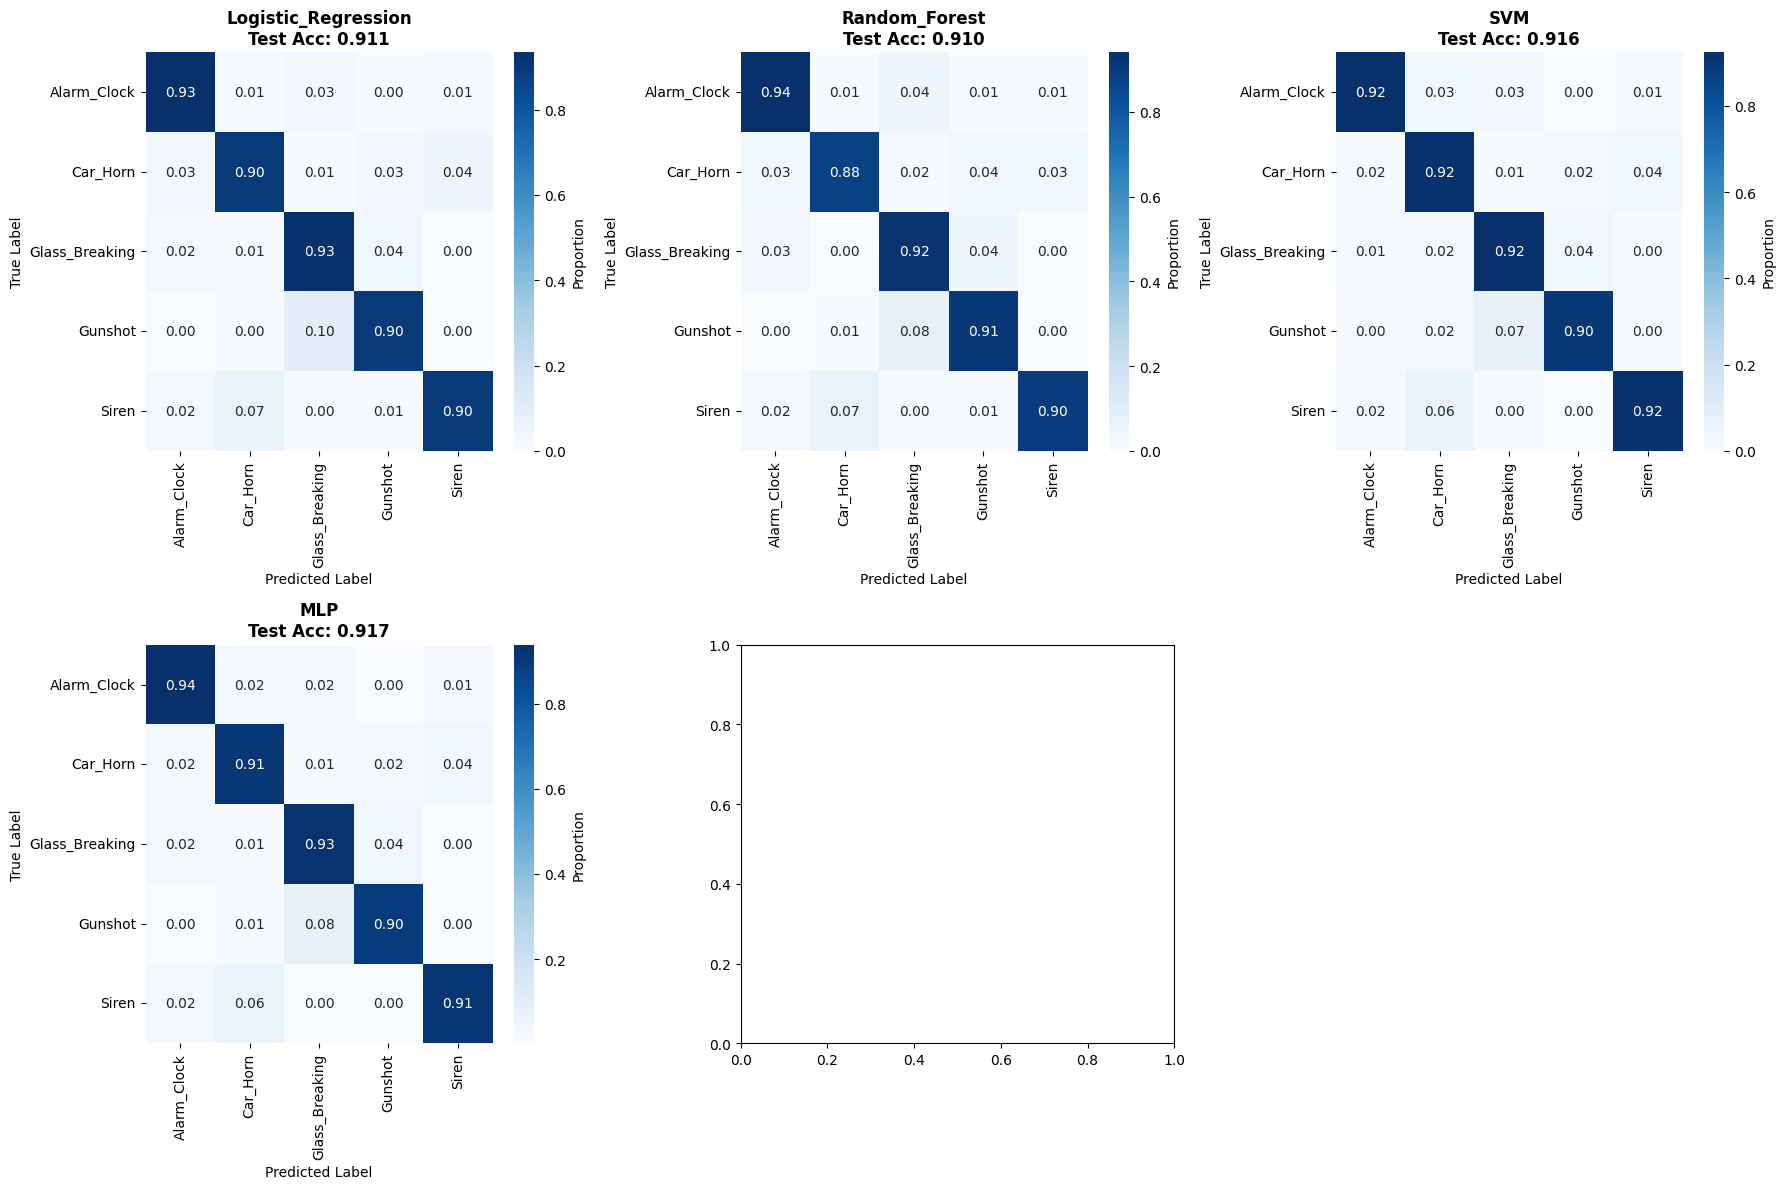

In [9]:
# CONFUSION MATRICES
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (clf_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['test_predictions'])
    
    # Normalize
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=classes, yticklabels=classes, ax=axes[idx],
               cbar_kws={'label': 'Proportion'})
    
    axes[idx].set_title(f'{clf_name}\nTest Acc: {result["test_metrics"]["accuracy"]:.3f}',
                       fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide last subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

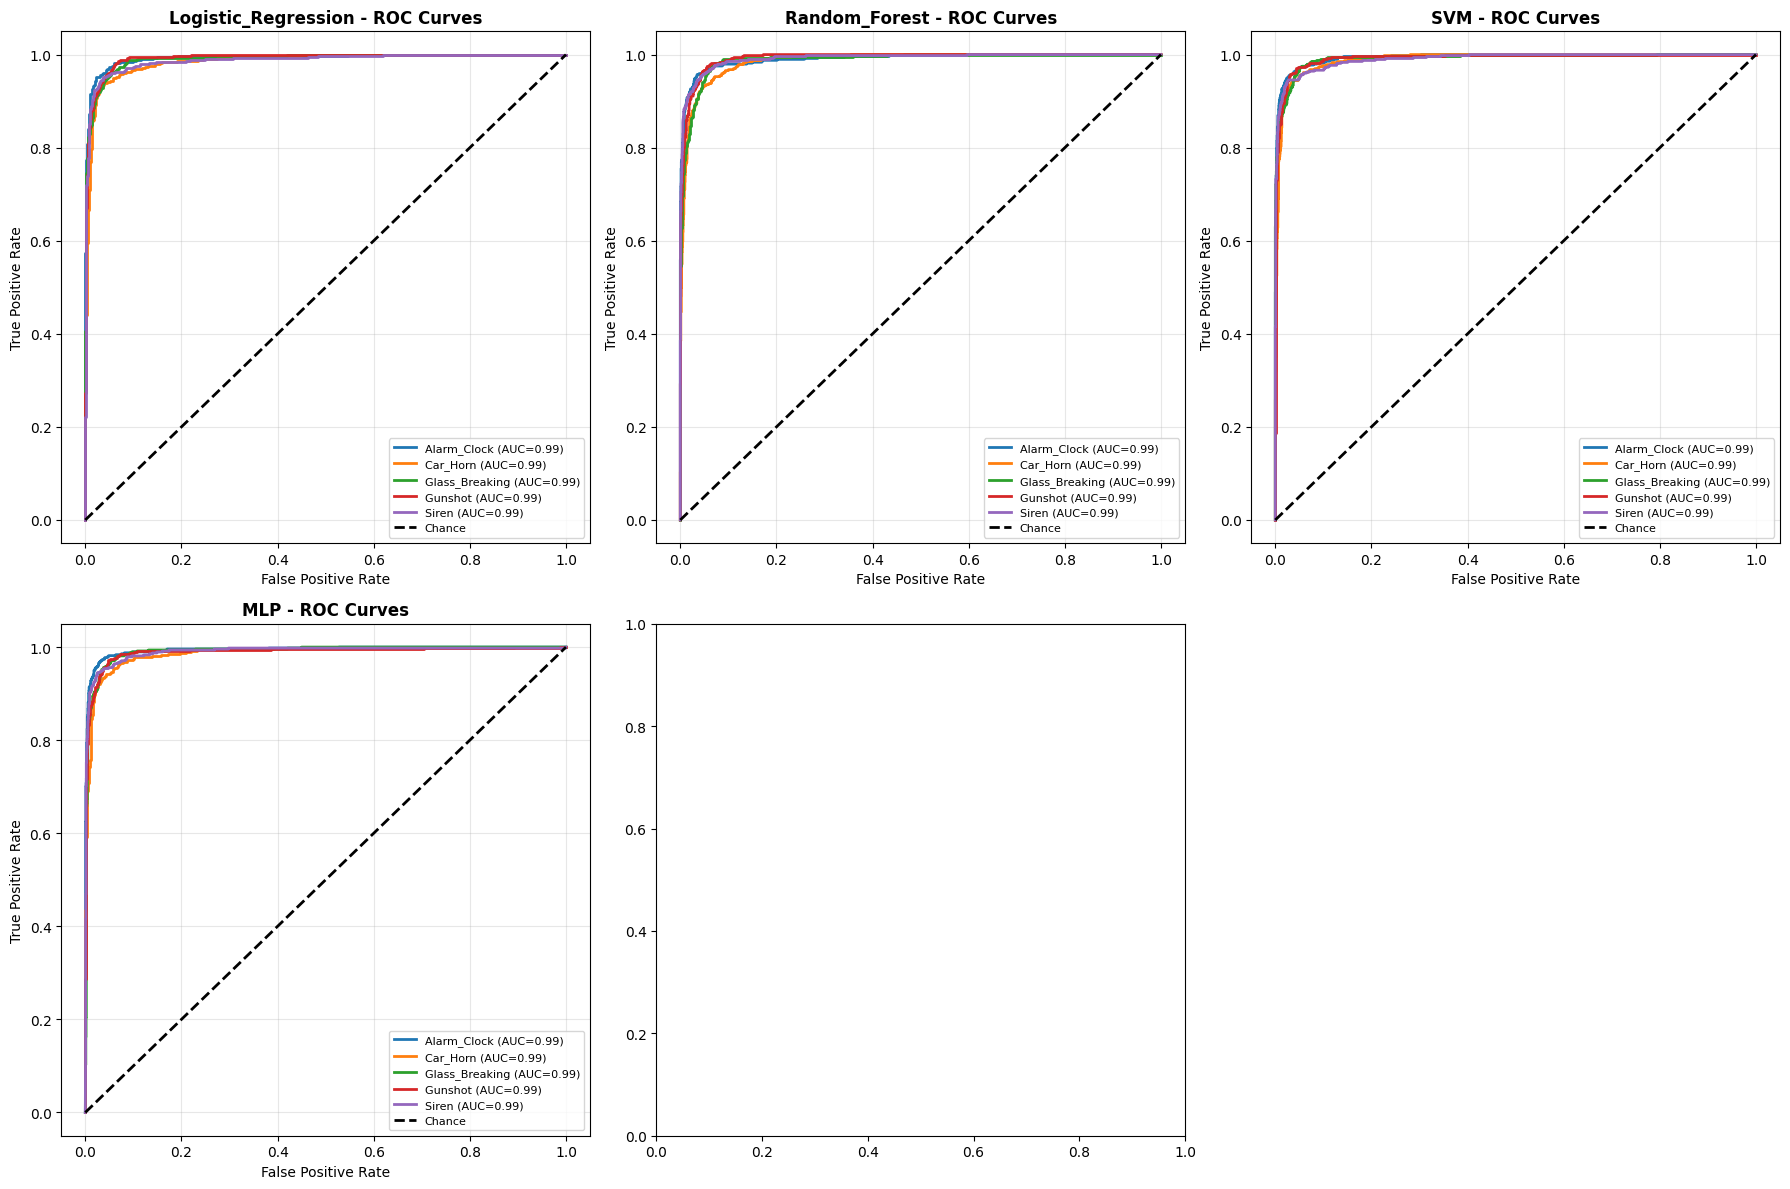

In [10]:
# ROC CURVES (One-vs-Rest)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (clf_name, result) in enumerate(results.items()):
    y_test_proba = result['test_proba']
    
    # Compute ROC curve for each class
    for i, class_name in enumerate(classes):
        y_test_binary = (y_test == i).astype(int)
        fpr, tpr, _ = roc_curve(y_test_binary, y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        axes[idx].plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')
    
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{clf_name} - ROC Curves', fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=8)
    axes[idx].grid(alpha=0.3)

axes[-1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

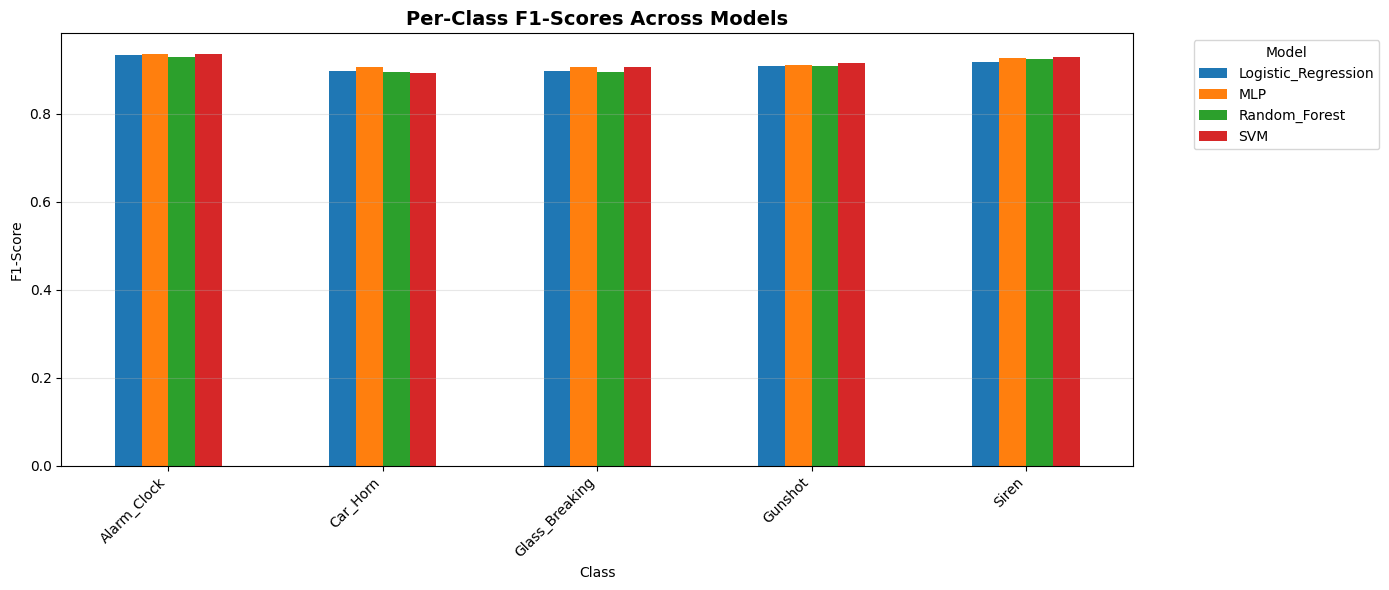

In [11]:
# PER-CLASS PERFORMANCE

# Calculate per-class F1 scores
per_class_data = []

for clf_name, result in results.items():
    y_pred = result['test_predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    for i, class_name in enumerate(classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        per_class_data.append({
            'Model': clf_name,
            'Class': class_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': cm[i, :].sum()
        })

per_class_df = pd.DataFrame(per_class_data)

# Pivot for visualization
f1_pivot = per_class_df.pivot(index='Class', columns='Model', values='F1-Score')

plt.figure(figsize=(14, 6))
f1_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Per-Class F1-Scores Across Models', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'per_class_f1_scores.png'), dpi=300, bbox_inches='tight')
plt.show()


Random_Forest:
  Top feature index: 104
  Top feature importance: 0.020103


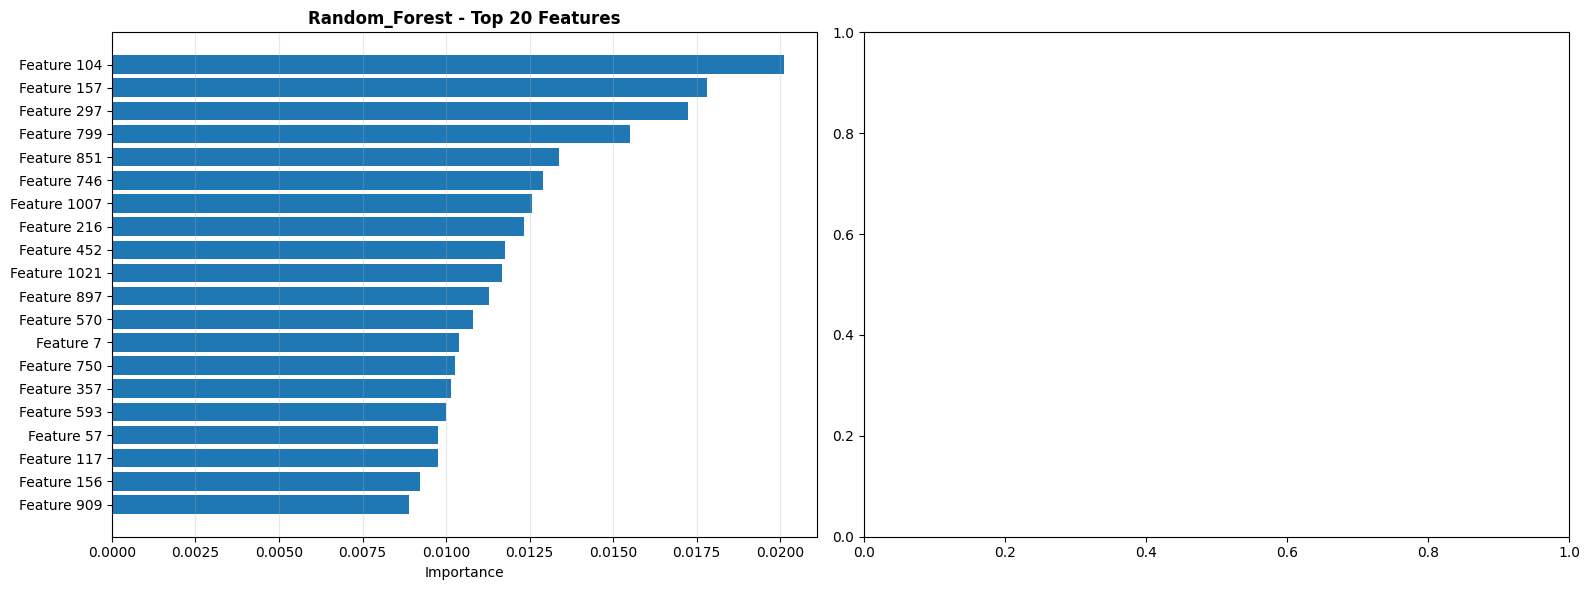

In [15]:
# FEATURE IMPORTANCE (for tree-based models)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

tree_models = ['Random_Forest']
for idx, model_name in enumerate(tree_models):
    if model_name in best_models:
        model = best_models[model_name]
        
        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Get top 20 features
            top_indices = np.argsort(importances)[-20:]
            top_importances = importances[top_indices]
            
            axes[idx].barh(range(len(top_importances)), top_importances)
            axes[idx].set_yticks(range(len(top_importances)))
            axes[idx].set_yticklabels([f'Feature {i}' for i in top_indices])
            axes[idx].set_xlabel('Importance')
            axes[idx].set_title(f'{model_name} - Top 20 Features', fontweight='bold')
            axes[idx].grid(axis='x', alpha=0.3)
            
            print(f"\n{model_name}:")
            print(f"  Top feature index: {top_indices[-1]}")
            print(f"  Top feature importance: {top_importances[-1]:.6f}")

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# Save label encoder
label_encoder_path = os.path.join(MODELS_DIR, 'label_encoder.pkl')
joblib.dump(label_encoder, label_encoder_path)
print(f"Saved label encoder: {label_encoder_path}")

# Save results dictionary
results_path = os.path.join(RESULTS_DIR, 'training_results.pkl')
joblib.dump(results, results_path)
print(f"Saved training results: {results_path}")

# Save per-class performance
per_class_path = os.path.join(RESULTS_DIR, 'per_class_performance.csv')
per_class_df.to_csv(per_class_path, index=False)
print(f"Saved per-class performance: {per_class_path}")

Saved label encoder: ../models/models_approach1\label_encoder.pkl
Saved training results: ../results/results_approach1\training_results.pkl
Saved per-class performance: ../results/results_approach1\per_class_performance.csv


In [17]:
# FINAL SUMMARY
print(f"\nTrained {len(classifiers)} classifiers")
print(f"Best model: {best_model_name}")
print(f"Best test F1-score: {comparison_df.iloc[0]['Test F1']:.4f}")
print(f"Models saved to: {MODELS_DIR}")
print(f"Results saved to: {RESULTS_DIR}")


Trained 4 classifiers
Best model: MLP
Best test F1-score: 0.9172
Models saved to: ../models/models_approach1
Results saved to: ../results/results_approach1
